# Domain-specific task: classifying polymers # 

In this exercise, you are tasked with performing k-means clustering on dataset of polymer properties. This exercise should give you a practical understanding of how to implement k-means as well as exposure to one flavor of the many kinds of tasks you will be asked to perform in internship settings. It is important to have an appreciation for the "big picture" when it come to data science and what you are actually trying to achieve, regardless of domain.

<ins>Motivation</ins>: You are working for a materials supplier and your boss needs to know what kind of polymer will work best in a given situation (maybe for a playground slide). It is important that the polymer of choice withstand high temperatures without deforming easily under pressure. A material's ability to resist deformation is measured by its Elastic and Shear Moduli (Elastic being relevant in settings of tension, Shear being relevant in settings of torsion or shearing). Shearing will be important here given the way that children will use the slide. Polymers also contain a specific material property known as the Glass Transition Temperature. This temperature determines the limit at which the polymer's stiffness (or, ability to resist deformation) breaks down. You know that polymers typically come in three categories, described by their degree of cross-linking (i.e. the density of chemical bonds between adjacent molecular polymer strands) and their ability to deform without permament damage):

<ul>    
<li>Thermosets (high cross-linking, high resistance to deformation)</li>
<li>Thermoplastics (no cross-linking, moderate resistance to deformation)</li>
<li>Elastomers (low to moderate cross-linking, low resistance to deformation, but no permanent deformation)</li>
    
</ul>

<ins>Task</ins>: Your advisor has a dataset of polymers, but he does not have the names of these polymers or their types (this might be a common case if the materials developed are highly secretive). The dataset includes the values of their shear moduli, glass transition temperature, density, the precision of the density measurements, and 3 categorical variables: (1) whether the polymer melts or burns (a distinguishing factor for thermosets is that they burn rather than melt), (2) the degree of cross-linking (thermoplastics have no cross-linking, elastomers have low to moderate, and thermosets have high cross-linking), and (3) the degree of elongation (i.e. how far the material can be stretched before deforming permanently). With only this dataset, use k-means to systematically separate the data points into three categories: thermosets, thermoplastics, and elastomers.   

## Step 1: Data visualization ##

Let's take a look at the dataset your boss gave you:

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [2]:
polymers_df = pd.read_csv("./PolymersData.csv")

In [3]:
polymers_df.head()

,Polymer Name,Polymer Type,Glass Transition Temperature (K),Reduced Glass Transition Temperature (293/T_g),Shear Modulus (MPa),Density (g/cm^3),Density Measurement Precision (no. sig figs),Melt or Burn?,Level of Cross-Linking,Elongation
0,Polyvinyl-carbazol,thermoplastic,476,0.615,1278.8,1.200,2,melt,none,moderate
1,Polycarbonate,thermoset,437,0.671,1599.1,1.200,2,burn,high,low
2,Polychloromethacrylate,thermoplastic,431,0.679,2391.3,0.936,3,melt,none,moderate
3,Polystyrene,thermoplastic,390,0.752,1045.7,1.050,3,melt,none,moderate
4,Polymethacrylsauremethylester,thermoset,387,0.756,1222.9,2.000,1,burn,high,low


In [4]:
polymers_df = polymers_df.drop(['Polymer Name'], axis=1)
cat2num = {'Melt or Burn?' : {'melt' : 0, 'burn' : 1},
           'Level of Cross-Linking' : {'none' : 0, 'low' : 1, 'moderate' : 2, 'high' : 3},
           'Elongation' : {'low' : 0, 'moderate' : 1, 'high' : 2}}

polymers_df.replace(cat2num, inplace=True)

We'll plot the shear modulus against the glass transition temperature:

In [5]:
def plot_data(df, x, y, hue=None, logscale=False):
    sns.set_style('whitegrid')
    fig = sns.lmplot(x=x, y=y, 
               data=df, hue=hue, palette='coolwarm',
               height=6, aspect=1, fit_reg=False)

    ax = fig.axes[0][0]
    if logscale:
        ax.set_yscale('log')
    return

def df2np(df, xs, label):
    X = df[xs].to_numpy()
    y = df[label].to_numpy()
    return X, y

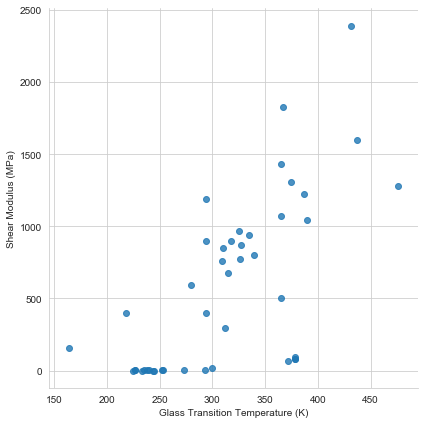

In [6]:
plot_data(df=polymers_df, 
          x='Glass Transition Temperature (K)', 
          y='Shear Modulus (MPa)',
          logscale=False)

This does not give us much intuition in terms of separating data points. However, it looks like there are a group of points clustered at very low shear moduli. Let's try plot the shear modulus on a log scale:

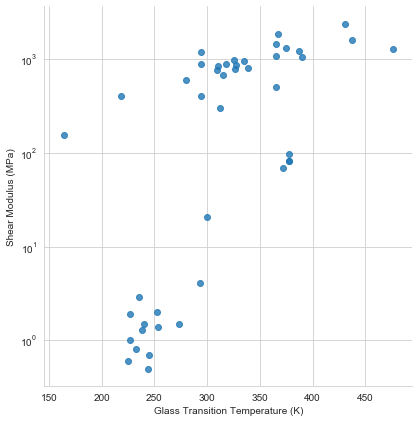

In [7]:
plot_data(df=polymers_df, 
          x='Glass Transition Temperature (K)', 
          y='Shear Modulus (MPa)',
          logscale=True)

Now we are starting to see some significance in the separation between the data points. Though, it is still hard to discern 3 distinct clusters of materials. Let's take a look at density and glass transition temperature as well as density and shear modulus:

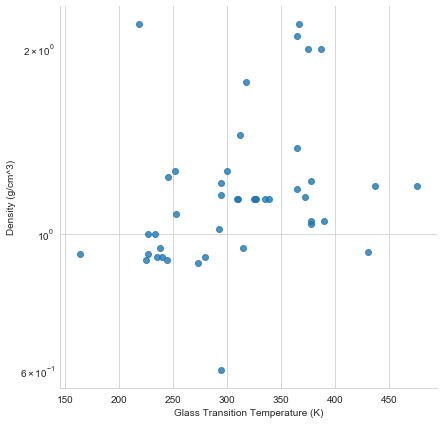

In [8]:
plot_data(df=polymers_df, 
          x='Glass Transition Temperature (K)', 
          y='Density (g/cm^3)',
          logscale=True)

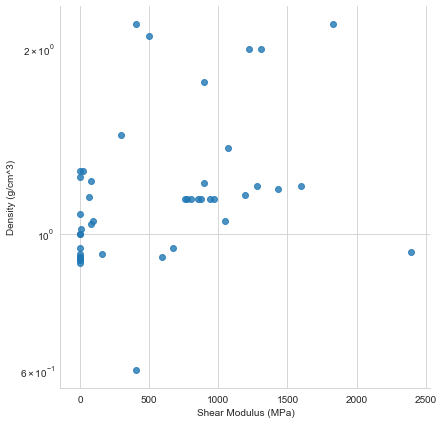

In [9]:
plot_data(df=polymers_df, 
          x='Shear Modulus (MPa)', 
          y='Density (g/cm^3)',
          logscale=True)

These scatter plots are even harder to discern specific clusters of materials. Let's try using PCA to reduce the dimensionality of our dataset, taking advantage of our categorical features as well:

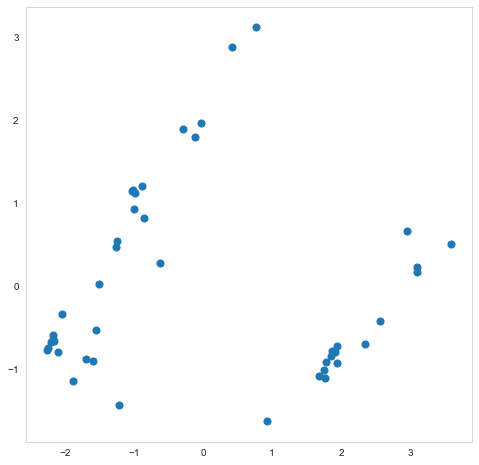

In [10]:
#### Sanity Checks ####

## PCA on Dataset

features = ['Glass Transition Temperature (K)', 'Shear Modulus (MPa)', 'Density (g/cm^3)', 'Level of Cross-Linking', 'Melt or Burn?', 'Elongation']

x = polymers_df.loc[:, features].values

y = polymers_df.loc[:, ['Polymer Type']].values

x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents,
                          columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, polymers_df[['Polymer Type']]], axis=1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

### show labels ###
'''targets = ['thermoset', 'thermoplastic', 'elastomer']
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['Polymer Type'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
               finalDf.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 50)'''

### omit labels ###
ax.scatter(finalDf['principal component 1'], finalDf['principal component 2'], s=50)

#ax.legend(targets)
ax.grid()

In [11]:
### KMeans ###

X,y = df2np(df=finalDf, xs=['principal component 1', 'principal component 2'], label='Polymer Type')

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.labels_

array([2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
       2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2],
      dtype=int32)

In [12]:
kmeans.cluster_centers_

array([[-1.92166274, -0.7162004 ],
       [ 2.19379322, -0.58250456],
       [-0.58552951,  1.38191989]])

(This clustering has 2 misclassified datapoints, index 23 and 29)

## Step 2: k-Means Implementation

Let $X$ denote the set of $N$ data points $\vec{x_i} \in \mathbb{R}^d$. A cluster assignment is a partition $C_1, ..., C_k \in X$ such that the sets $C_k$ are disjoint and $X = C_1 \cup ... \cup C_k$. A data point $\vec{x_i} \in X$ is said to belong to cluster $k$ if it is in $C_k$.

Formally, k-Means solves the following optimization problem: $\underset{\{C_k\}_{k = 1}^{K}, \{\vec{c_k}\}_{k = 1}^{K}: X = C_1 \cup ... \cup C_K}{\arg\min} \sum_{k = 1}^{K} \underset{\vec{x} \in C_k}{\sum} \|\vec{x} - \vec{c_k}\|^2$ 

More informally, k-Means is trying to find the best cluster centers & assignments that maximizes the distance between clusters and minimizes the size of each cluster. In other words, we want to find clusters that are as far apart (distinct) from each other as possible, while making sure that all the points in a cluster are pretty close to each other. 

Solving this optimization problem directly is NP-hard (i.e. computationally very difficult). Instead, we use Lloyd's Algorithm: 
1. Pick some K representing the number of groups you wish to cluster your datset into
2. Randomly initialize $\vec{c_k}, k = 1,...,K$
3. While $\vec{c_k}$ keeps changing (k-Means has not converged): 
    * Update partition $C_1 \cup ... \cup C_k$ given by the $\vec{c_k}$ by assigning each $\vec{x_i} \in X$ to the cluster represented by its nearest centroid: $\underset{k}{\arg\min} \|\vec{x} - \vec{c_k}\|^2$
    * Update centroid $\vec{c_k}$ given $C_1 \cup ... \cup C_k$ as $\vec{c_k} = \frac{1}{\lvert {C_k} \rvert} \sum_{\vec{x} \in C_k} \vec{x}$

This algorithm will always converge to some value becaue each step in (3) is guaranteed to not increase the value of the objective function. This two-step algorithm can be implemented using the help of two functions: 
1. assign_clusters: given a set of clusters, assign each data point to the best cluster
2. update_means: given a set of cluster assignments, compute the new best cluster center (a.k.a. centroid)

#### TODO: complete the implementations of assign_clusters and update_means below

In [40]:
def assign_clusters(X, c): 
    """
    Takes in an (n x d) data matrix X, and a (k x d) matrix of the centroids c. 
    Returns a length-n vector with the index of the closest centroid to each data point.
    """
    n, d = X.shape
    k = c.shape[0]
    assert d == c.shape[1], "Centroids are of the wrong shape"
    assignments = np.zeros(n)
    for i, point in enumerate(X): 
        #TODO: Set assignments[i] to be the index of the centroid who is closest to the current point
        ### start assign_cluster ###
        ############################
        assignments[i] = min(range(k), key = lambda j: np.linalg.norm(point - c[j]))
        ###########################
        ### end assign_cluster ###
    return assignments

def update_means(X, assignments): 
    """
    Takes in an (n x d) data matrix X, and a length-n vector of
    the cluster indices of each point.
    Computes the mean of each cluster and returns a (k x d) matrix of the centroids.
    """
    n, d = X.shape
    assert len(assignments) == n
    k = len(set(assignments))
    centroids = []
    for i in range(k): 
        #TODO: set centroid_i to be the mean of all points in cluster 'i'
        ### start update_means ###
        cluster_points = X[assignments == i]
        centroid_i = np.mean(cluster_points, axis = 0)
        ### end update_means ###
        centroids.append(centroid_i)
    return np.array(centroids)

Along with assign_clusters and update_means, we need a few other helper functions to have a working k-Means implementation: 
1. initialize_centroids: this will randomly pick k number of data points to serve as the initial centroids to pass into assign_clusters to kickstart the algorithm. 
2. cost: unlike supervised learning problems where we can measure training error by calculating the distance between our model output and the true output, unsupervised learning does not have the same luxury. We actually don't have access to the true clusters that the data points belong to, so we have to come up with a different measure of how well or poor our clustering is. For this demo, we will use the summ of squared distance of each data point to its centroid as a measure of cost. 

#### TODO: Complete the implementations of initialize_centroids and cost below

In [146]:
def initialize_centroids(X, k): 
    """
    Takes in an (n x d) data matrix X, and employs forgy initialization, where the initialized centroids are
    randomly chosen from the input data set. 
    """
    n, d = X.shape
    #TODO: Set centroids to be k randomly picked data points from X
    ### start initialize_centroids ###
    ##################################
    np.random.seed(0)
    centroids = X[np.random.choice(n, k, replace = False)]
    ################################
    ### end initialize_centroids ###
    return centroids

def cost(X, assignments, centroids): 
    """
    Computes the sum of the squared distance between each point
    and the mean of its associated cluster. 
    Remember: k-Means seeks to minimize intra-cluster distance 
    and maximize inter-cluster distance.
    """
    total_cost = 0
    n, d = X.shape
    k = centroids.shape[0]
    assert centroids.shape[1] == d
    assert len(assignments) == n
    for i in range(k): 
        #TODO: set cost_i to be the sum of squared distance from all points in cluster 'i' to centroid 'i'
        ### start cost ###
        ##################
        cost_i = np.linalg.norm(X[assignments == i] - centroids[i])**2
        ################
        ### end cost ###
        total_cost += cost_i
    return total_cost

All of these functions together will give us a working k-Means implementation. We've provided a function that will run through Lloyd's algorithm and call each of these function individualy. We've also included a few more functions that will help us visualize our results. No need to modify any of the functions below. 

In [147]:
def k_means(X, k): 
    """
    Take in an (n x d) data matrix X and a parameter 'k' representing the number of clusters. 
    Yields the centroids and cluster assignments after each step 
    of running k-means in a 2-tuple.
    """
    n, d = X.shape
    centroids = initialize_centroids(X, k)
    assignments = assign_clusters(X, centroids)
    
    steps = []
    
    while True: 
        steps.append((centroids, assignments))
        centroids = update_means(X, assignments)
        new_assignments = assign_clusters(X, centroids)
        if np.all(assignments == new_assignments): 
            steps.append((centroids, assignments))
            error = cost(X, assignments, centroids)
#             print(f'Final cost = {cost(X, assignments, centroids)}')
            break
        assignments = new_assignments
    
    return steps, error

def package_implementation(X, k):
    """
    Takes in an (n x d) matrix X and a parameter 'k' representing the number of clusters. 
    Returns the final (centroid, assignments) tuple.
    """
    kmeans = KMeans(n_clusters=k, n_init=1, init=initialize_centroids(X, k)).fit(X)
    assignments = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    return (centroids, assignments, kmeans.inertia_)

def final_k_means_cluster(X, k): 
    steps, cost = k_means(X, k)
    return steps[-1][0], steps[-1][1], cost

def plot_clustering(X, centroids, assignments): 
    k = len(centroids)
    for j in range(k): 
        plt.scatter(*X[assignments == j].T)
    plt.scatter(*centroids.T, marker='x', s = 240, c = 'black')
    plt.show()

def interact_clustering(X, logger): 
    history = list(logger)
    k = history[0][0].shape[0]
    
    def plotter(i): 
        plot_clustering(X, *history[i])
    
    interact(plotter, i = IntSlider(min=0, max=len(history) - 1, continuous_update = False))

def demo(classes, history= False): 
    for c in classes: 
        plt.scatter(*c.T)
    plt.show()
    
    points = np.vstack(classes)
    
    if history: 
        interact_clustering(points, k_means_cluster(points, len(classes)))
    else: 
        centroids, assignments = final_k_means_cluster(points, len(classes))
        plot_clustering(points, centroids, assignments)

Before we can continue, we should make sure that our implementation is working properly. Let's compare the results of our k-Means implementation with Sklearn's implementation on our dataset X projected onto its first 2 principal components. This way, we can actually visualize the clusters in 2D space. If we were to work with the raw dataset in dimensions greater than 3, we couldn't visualize the clusters & would have to rely on our measure of cost to determine how effective the clusters were. 

19.413469294094266


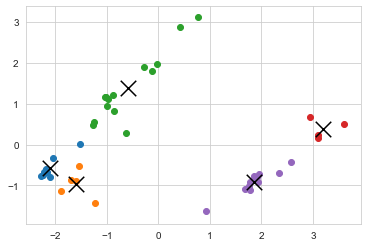

In [148]:
centroids, assignments, total_distance_cost = final_k_means_cluster(X, k=5)
print(total_distance_cost)
plot_clustering(X, centroids, assignments)

19.413469294094266


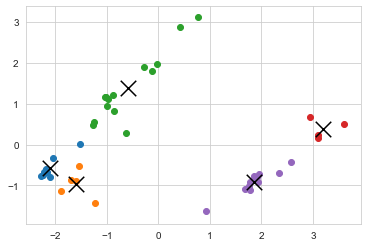

In [149]:
centroids, assignments, total_distance_cost = package_implementation(X, k=5)
print(total_distance_cost)
plot_clustering(X, centroids, assignments)

Did your prediction match the results of the demo? Why or why not? 
#### Answer: 

## Step 3: Tuning our k-Means Implementation

There are many things we could do to adjust our k-Means implementation to get different clustering results. We'll focus on two different tactics for finding the best parameters to feed into our k-Means implementation: 
1. The number of clusters, K: this will determine how many classes we're left with after our data is clustered. Traditionally, this is either picked using domain knowledge, cross-validation, or a little bit of both. 
2. The dimensionality of data: we can choose to either pass in the raw data, or we can reduce the dimensions of the data. Sometimes, reducing the dimensionality can yield much better clusters because we're only concerning ourselves with the most important components of the data. We saw earlier that projecting the data onto its first two principal components made the data visualization look really different. We can see how clustering might change if we change the number of principal components we project onto. 

Because we are trying to find both the best 'K' hyperparameter value and the best dimension, d,  for the training data, we can perform cross validation through grid search. However, it would be computationally inefficient to do a grid search for all possible values that K and d can take. 

What ranges for K and d should we perform grid search over? 

#### Answer: 

A good sanity check would be to look at the clusters created for different values of k.

#### TODO: change num_clusters to visualize the output of k-Means for different values of k when projecting onto d=2 dimensions.

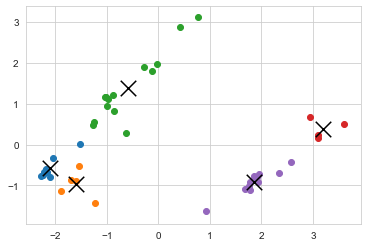

In [80]:
num_clusters = 5
centroids, assignments, total_distance_cost = final_k_means_cluster(X, k=num_clusters)
plot_clustering(X, centroids, assignments)

We can't perform the same sanity check to look at which projections give us the best clusters because we can't visualize dimensions beyond 3D. Typically, in practice, it's difficult to determine which dimension to project the data into and many data scientists often do this by trial and error. For the purposes of our project, your boss tells you to work in 3 dimensions so that you can easily visualize the different clusters that form. 

#### TODO: pick values for max_k. Depending on the values you pick, the performance of the cross validation will change accordingly

In [174]:
max_k = 10
prospective_k = range(1, max_k + 1)

d = 3

In [183]:
def perform_k_means(k, d, X): 
    pca = PCA(n_components=d)
    principalComponents = pca.fit_transform(X)
    return final_k_means_cluster(principalComponents, k=k)

def cross_validation(arr_k, d, X): 
    all_centroids = []
    all_assignments = []
    all_costs = np.zeros((len(arr_k)))
    for i in range(0, len(arr_k)): 
        centroids, assignments, total_distance_cost = perform_k_means(arr_k[i], d, X)
        all_centroids.append(centroids)
        all_assignments.append(assignments)
        all_costs[i] = total_distance_cost
    
#     p = PrettyTable()
#     p.field_names = ["k"] + list(arr_d)
#     for row in range(0, len(all_costs)):
#         p.add_row([arr_k[row]] + list(all_costs[row]))

#     print(p)
#     print(f'Optimal k: {arr_k[best_index]}')
    
    return all_costs, all_centroids, all_assignments
    

In [184]:
min_cost, centroids, assignments = cross_validation(prospective_k, d, x)

Unlike with other hyperparameters that we've seen before, like polynomial degree, the number of clusters hyperparameter is not expected to have a clear minimum 

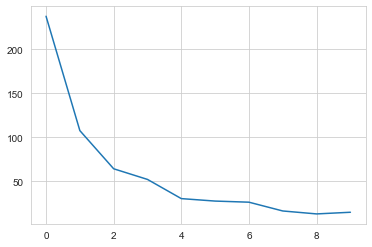

In [185]:
plt.plot(min_cost)

Based on the results of the cross-validation, what is the optimal value of k and d? Also, report the min and max costs of clustering. 

#### Answer: 

Does this make sense intuitively? Why or why not? 

#### Answer: 

In [134]:
x.shape

(44, 6)

In [167]:
print(min_cost[:, 2])

[250.08773593 120.22454552  75.85055614  63.43320987  41.61281345
  38.56901294  37.04944032  27.27211916  25.825062    28.88931095]


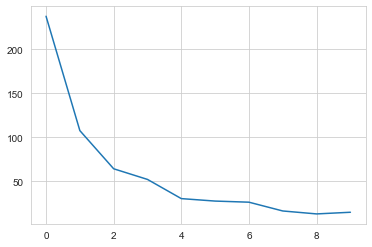

In [169]:
plt.plot(min_cost[:, 1])

ValueError: Unrecognized marker style array([], shape=(44, 0), dtype=float64)

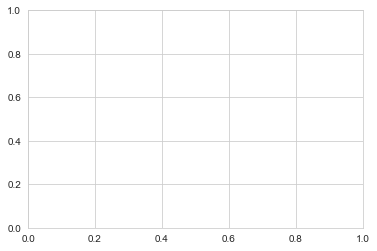

In [163]:
plot_clustering(x, centroids, assignments)